#  <center> Counterfactual analysis tutorial2 <center>
<center> Spring 2023 <center>
<center> 3.C01/3.C51, 10.C01/10.C51, 20.C01/20.C51 <center>
<center> No deadline, not graded <center>

## 1. Predicting drug activity with Graph Convolutional Nets

In [2]:
!pip install rdkit

In [1]:
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import torch

from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*') # turn off RDKit warning message 

/home/soojungy/miniconda3/envs/torchmd/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Downloading BACE dataset
! wget https://raw.githubusercontent.com/SoojungYang/ML4MolEng_Spring2023/main/BACE_clean.csv

--2023-05-08 13:33:09--  https://raw.githubusercontent.com/SoojungYang/ML4MolEng_Spring2023/main/BACE_clean.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98109 (96K) [text/plain]
Saving to: ‘BACE_clean.csv’

BACE_clean.csv      100%[===================>]  95.81K  --.-KB/s    in 0.008s  

2023-05-08 13:33:10 (12.1 MB/s) - ‘BACE_clean.csv’ saved [98109/98109]



A smiles to graph conversion function. 

In [3]:
def smiles2graph(smiles):
    '''
    Transform smiles into a list of atomic numbers and an edge array
    
    Args: 
        smiles (str): SMILES strings
    
    Returns: 
        z(np.array), A (np.array): list of atomic numbers, edge array
    '''
    
    mol = Chem.MolFromSmiles( smiles ) # no hydrogen 
    z = np.array( [atom.GetAtomicNum() for atom in mol.GetAtoms()])
    A = np.stack(Chem.GetAdjacencyMatrix(mol)).nonzero()
    
    return z, A

Read the dataframe, shuffle its rows, and store its properties as lists. 

In [4]:
df = pd.read_csv("BACE_clean.csv")
df = shuffle(df).reset_index()

AtomicNum_list = []
Edge_list = []
y_list = []
Natom_list = []

for i, row in df.iterrows():
        smiles = row.smiles
        z, a = smiles2graph(smiles)

        mol = Chem.MolFromSmiles( smiles ) 
        AtomicNum = torch.LongTensor(z)
        AtomicNum_list.append(AtomicNum)
        Edge_list.append(torch.LongTensor(a))
        y_list.append(torch.FloatTensor([row.label]))
        
        Natom_list.append(len(z))

/tmp/ipykernel_1182567/2121260417.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/torch/csrc/utils/tensor_new.cpp:210.)
  Edge_list.append(torch.LongTensor(a))


In [5]:
# print the number of positive samples and the negative samples
print("number of positive samples: ", len(df.loc[df.label==1]))
print("number of negative samples: ", len(df.loc[df.label==0]))

number of positive samples:  668
number of negative samples:  814


A code for GNN classification model

In [16]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self,
                 AtomicNum_list, 
                 Edge_list, 
                 Natom_list, 
                 y_list):
        
        '''
        GraphDataset object
        
        Args: 
            z_list (list of torch.LongTensor)
            a_list (list of torch.LongTensor)
            N_list (list of int)
            y_list (list of torch.FloatTensor)

        '''
        self.AtomicNum_list = AtomicNum_list # atomic number
        self.Edge_list = Edge_list # edge list 
        self.Natom_list = Natom_list # Number of atoms 
        self.y_list = y_list # properties to predict 

    def __len__(self):
        return len(self.Natom_list)

    def __getitem__(self, idx):
        
        AtomicNum = torch.LongTensor(self.AtomicNum_list[idx])
        Edge = torch.LongTensor(self.Edge_list[idx])
        Natom = self.Natom_list[idx]
        y = torch.Tensor(self.y_list[idx])
        
        return AtomicNum, Edge, Natom, y

In [17]:
from sklearn.model_selection import train_test_split

AtomicNum_train, AtomicNum_test, Edge_train, Edge_test, Natom_train, Natom_test, y_train, y_test = train_test_split(AtomicNum_list, 
                                                                                      Edge_list, 
                                                                                      Natom_list, 
                                                                                      y_list, test_size=0.2)

AtomicNum_train, AtomicNum_val, Edge_train, Edge_val, Natom_train, Natom_val, y_train, y_val = train_test_split(AtomicNum_train, 
                                                                                      Edge_train, 
                                                                                      Natom_train, 
                                                                                      y_train, test_size=0.1/0.8)

train_dataset = GraphDataset(AtomicNum_train, 
                            Edge_train, 
                            Natom_train,
                            y_train)
val_dataset = GraphDataset(AtomicNum_val,
                          Edge_val, 
                          Natom_val, 
                          y_val)
test_dataset =  GraphDataset(AtomicNum_test, 
                            Edge_test, 
                            Natom_test, 
                            y_test)

In [18]:
# collage_graphs() function is used to batch multiple graphs into one batched graph
# the function is used in the DataLoader to batch multiple graphs into one batched graph

def collate_graphs(batch):
    '''Batch multiple graphs into one batched graph
    
    Args:
    
        batch (tuple): tuples of AtomicNum, Edge, Natom and y obtained from GraphDataset.__getitem__() 
        
    Return 
        (tuple): Batched AtomicNum, Edge, Natom, y
    
    '''
    
    AtomicNum_batch = []
    Edge_batch = []
    Natom_batch = []
    y_batch = []

    cumulative_atoms = np.cumsum([0] + [b[2] for b in batch])[:-1]
    
    for i in range(len(batch)):
        z, a, N, y = batch[i]
        index_shift = cumulative_atoms[i]
        a = a + index_shift
        AtomicNum_batch.append(z) 
        Edge_batch.append(a)
        Natom_batch.append(N)
        y_batch.append(y)
        
    AtomicNum_batch = torch.cat(AtomicNum_batch)
    Edge_batch = torch.cat(Edge_batch, dim=1)
    Natom_batch = Natom_batch
    y_batch = torch.cat(y_batch)
    
    return AtomicNum_batch, Edge_batch, Natom_batch, y_batch 

In [19]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset,
                          batch_size=64, 
                          collate_fn=collate_graphs,shuffle=True)

val_loader = DataLoader(val_dataset,
                          batch_size=64, 
                          collate_fn=collate_graphs,shuffle=True)

test_loader = DataLoader(test_dataset,
                          batch_size=64, 
                          collate_fn=collate_graphs,shuffle=True)

In [20]:
from itertools import repeat
def scatter_add(src, index, dim_size, dim=-1, fill_value=0):
    
    '''
    Sums all values from the src tensor into out at the indices specified in the index 
    tensor along a given axis dim. 
    '''
    
    index_size = list(repeat(1, src.dim()))
    index_size[dim] = src.size(dim)
    index = index.view(index_size).expand_as(src)
    
    dim = range(src.dim())[dim]
    out_size = list(src.size())
    out_size[dim] = dim_size

    out = src.new_full(out_size, fill_value)

    return out.scatter_add_(dim, index, src)

In [21]:
from torch import nn
from torch.nn import ModuleDict

class GNN(torch.nn.Module):
    '''
        A GNN model 
    '''
    def __init__(self, n_convs=3, n_embed=64):
        super(GNN, self).__init__()
        
        self.atom_embed = nn.Embedding(100, n_embed)
        self.convolutions = nn.ModuleList(
            [ 
                ModuleDict({
                    'update_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                nn.ReLU(), 
                                                nn.Linear(n_embed, n_embed)),
                    'message_mlp': nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                 nn.ReLU(), 
                                                 nn.Linear(n_embed, n_embed)) 
                })
                for _ in range(n_convs)
            ]
            )
        # Declare readout layers
        self.readout = nn.Sequential(nn.Linear(n_embed, n_embed), nn.ReLU(), nn.Linear(n_embed, n_embed))
        self.final_layer = nn.Sequential(nn.Linear(n_embed, n_embed), nn.ReLU(), nn.Linear(n_embed, 1), nn.Sigmoid())
        
    def forward(self, AtomicNum, Edge, Natom):
        # Parametrize embedding 
        h = self.atom_embed(AtomicNum) #eqn. 1
        for conv in self.convolutions:
            msg = conv['message_mlp'](h[Edge[0]] * h[Edge[1]])
            dh = conv['update_mlp'](scatter_add(msg, Edge[0], dim=0, dim_size=h.shape[0]))
            h = h + dh 
        
        # node wise output 
        node_out = self.readout(h)
        # split nodes back to graphs 
        node_splits = torch.split(node_out, Natom)
        output = torch.stack([i.sum(0) for i in node_splits])
        output = self.final_layer(output)
        return output

In [22]:
# loop() function used to train and evaluate the model
loss_fn = nn.BCELoss()
def loop(model, loader, epoch, evaluation=False):
    
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = 'train'
    batch_losses = []
    
    # Define tqdm progress bar 
    tqdm_data = tqdm(loader, position=0, leave=True, desc='{} (epoch #{})'.format(mode, epoch))
    
    for data in tqdm_data:
        
        AtomicNumber, Edge, Natom, y = data 
        AtomicNumber = AtomicNumber.to(device)
        Edge = Edge.to(device)
        y = y.to(device)
        pred = model(AtomicNumber, Edge, Natom)
        loss = loss_fn(pred.squeeze(), y)
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ['batch loss={:.3f}'.format(loss.item()) , 
                   'avg. loss={:.3f}'.format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(' '.join(postfix))
    
    return np.array(batch_losses).mean()

### Train a GNN classifier

In [23]:
from torch import optim
device = 'cuda:0'
model = GNN(n_convs=3, n_embed=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=True)

for epoch in range(80):    
    train_loss = loop(model, train_loader, epoch)
    val_loss = loop(model, val_loader, epoch, evaluation=True)

eval (epoch #79): 100%|██████████| 3/3 [00:00<00:00, 106.87it/s, batch loss=0.645 avg. loss=0.521]


Evaluate the model performance. 

In [25]:
y_pred = []
y_true = []

for i, data in enumerate(test_loader, 0):
    AtomicNumber, Edge, Natom, y = data 
    AtomicNumber = AtomicNumber.to(device)
    Edge = Edge.to(device)
    y = y.to(device)
    pred = model(AtomicNumber, Edge, Natom)
    y_true += y.squeeze().tolist()
    
    pred = (pred.squeeze()>0.5).tolist()
    y_pred += pred

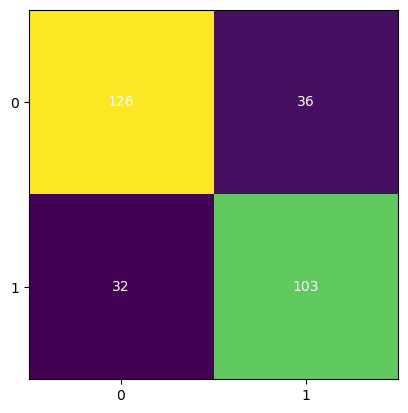

In [26]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(conf_mat)

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))

ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, conf_mat[i, j],
                       ha="center", va="center", color="w")

plt.show()

In [27]:
print("accuracy", (np.array(y_pred)==np.array(y_true)).sum()/len(y_pred))

accuracy 0.7710437710437711


## 2. Implement a custom counterfactual generator

In this project, we aim to develop a simple counterfactual generator for Graph Neural Networks (GNNs). Given a molecule and its true or predicted label, our objective is to generate a molecule that closely resembles the original molecule but has the opposite label.

To achieve this, we propose a method where we iteratively flip the atomic number of a randomly selected atom in the molecule and evaluate the model's prediction. If the model predicts the counterfactual label, we add the candidate molecule to a list of potential counterfactuals.

Once we have a list of potential counterfactuals, we transform the changed graphs into molecular objects and use the RDKit library to visualize the flipped atom. The resulting molecule with the highlighted flipped atom can then be analyzed by domain experts to assess its chemical plausibility and interpretability.

In [28]:
from rdkit import Chem

# we will use graph_to_mol() function to convert graph to molecule
atom_dict = {  6: 'C', 7: 'N', 8: 'O', 9: 'F', 
               15: 'P', 16: 'S', 17: 'Cl', 
               35: 'Br', 53: 'I',}

def graph_to_mol(x, Edge):
  """
  x: Atomic Number
  Edge: Edge List
  """
  atom_one_hot = x.detach().cpu().numpy()

  mol = Chem.RWMol() # generate empty mol object
  for i, atom_num in enumerate(atom_one_hot):
      atom_symbol = atom_dict[atom_num] # get atom symbol from atomic number
      atom = Chem.Atom(atom_symbol) # create atom object
      mol.AddAtom(atom) # add atom to mol object

  edge_list = Edge.detach().cpu().numpy().transpose(1,0) # get edge list from the original molecule
  for edge in edge_list:
    i, j = edge
    if i < j:
      mol.AddBond(int(i), int(j), Chem.rdchem.BondType.UNSPECIFIED) # add bond to mol object
  return Chem.RemoveHs(mol)

In [29]:
atom_list = torch.LongTensor([6, 7, 8, 9, 15, 16, 17, 35, 53])

def generate_candidates(x, A, Natom, y, model, num_candidates=10):
    """Generates candidate molecules with flipped atomic numbers."""
    candidates = [] # list of tuples (mol, prob), where mol is a counterfactual molecule 
                    # and prob is the probability of the counterfactual molecule being an active molecule
    
    x, A, y = x.to(device), A.to(device), y.to(device) # original molecule
    target_y = 1-y # counterfactual label

    for i in range(num_candidates):
        # Generate a random candidate molecule by flipping an atom
        x_ = x.clone()
        atom_idx = torch.randint(len(x), (1,)) # index of the atom to be flipped
        new_atom = torch.randint(1, 9, (1,)) # new atomic number
        x_[atom_idx] = atom_list[new_atom] # flip the atom

        # Evaluate the candidate molecule using the GNN model
        with torch.no_grad():
            prob = model(x_, A, Natom)[0] # probability of the candidate molecule being an active molecule
        
        # If the candidate molecule has the counterfactual label, add it to the list of candidates
        if (prob.item() > 0.5) == target_y.item(): 
            mol = graph_to_mol(x_, A) 
            candidates.append((mol, prob.item(), atom_idx))
        
    # Return the candidate molecules with the highest predicted probability of having the counterfactual label
    return sorted(candidates, key=lambda x: x[1]*(target_y.item()-0.5), reverse=True)

In [31]:
import random
# randomly select a molecule from the test set
AtomicNumber, Edge, Natom, y = test_loader.dataset.__getitem__(random.choices(range(len(test_loader.dataset)), k=1)[0])

In [34]:
print(y.item()) # label of the original molecule

1.0


In [32]:
# generate counterfactual molecules
candidates = generate_candidates(AtomicNumber, Edge, Natom, y, model, num_candidates=20)

In [35]:
candidates[:5] 
# print the top 5 candidates.
# Each candidate is a tuple (mol, prob, atom_idx), where mol is a counterfactual molecule,
# prob is the probability of the counterfactual molecule being an active molecule,
# and atom_idx is the index of the atom that was flipped to generate the counterfactual molecule.
# The top 5 candidates have the highest probability of being inactive molecules,
# as the original molecule is an active molecule.

[(<rdkit.Chem.rdchem.Mol at 0x7f8c4166d430>,
  0.00022889352112542838,
  tensor([17])),
 (<rdkit.Chem.rdchem.Mol at 0x7f8c41600580>,
  0.002324539003893733,
  tensor([13])),
 (<rdkit.Chem.rdchem.Mol at 0x7f8c41600120>,
  0.04616380110383034,
  tensor([24])),
 (<rdkit.Chem.rdchem.Mol at 0x7f8c4166d4a0>,
  0.09230900555849075,
  tensor([18])),
 (<rdkit.Chem.rdchem.Mol at 0x7f8c4166dac0>, 0.10565964877605438, tensor([4]))]

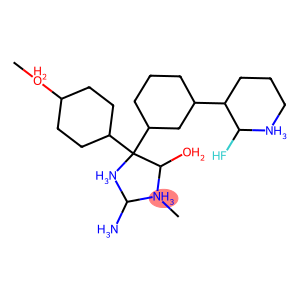

In [38]:
# generate an image of the original molecule
# bond orders are not specified in this image
# hydrogen atoms should be neglected when interpreting the image
# the atom with the flipped atomic number is highlighted in red
mol = graph_to_mol(AtomicNumber, Edge)
img = Draw.MolToImage(mol, removeHs=True, highlightAtoms=[candidates[0][-1].item()])
img

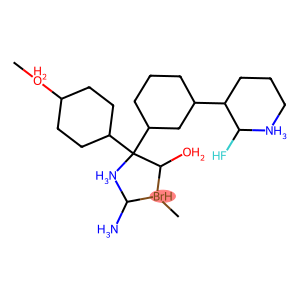

In [37]:
# generate an image of the top 1 candidate molecule
# bond orders are not specified in this image
# hydrogen atoms should be neglected when interpreting the image
# the atom that was flipped is highlighted in red
img = Draw.MolToImage(candidates[0][0], removeHs=True, highlightAtoms=[candidates[0][-1].item()])
img